# Analizando el modelo Sugarscape.
**A continuación se presenta un análisis de los datos arrojados por algunos experimentos realizados con el modelo de Sugarscape. Veremos la relación de la variable de dotación inicial (maximum-sugar-endowment y minimum-sugar-endowment) y las métricas del índice GINI, la cantidad de decesos por hambre (starvation), la riqueza per cápita y la cantidad promedio de cambios de azúcar tras aplicar las políticas de recaudación y redistribución. Los mapas de calor de cada experimentación pueden ser consultados a detalle en el otro notebook adjuntado.**
## Importando bibliotecas

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from pathlib import Path
sns.set()

# Métodos auxiliares

In [5]:
def limpiar_dataframe(df):
    limpiado = df.drop(columns='visualization')
    limpiado = limpiado.drop(limpiado[limpiado['[step]'] == 0].index) # aquellas runs que no se iniciaron
    # aquellas runs invalidas
    limpiado = limpiado.drop(limpiado[limpiado['maximum-sugar-endowment'] <= limpiado['minimum-sugar-endowment']].index)
    limpiado = limpiado.drop(columns='[run number]')
    limpiado = limpiado.drop(columns='initial-population') #poblacion fija
    limpiado = limpiado.drop(columns='[step]') # en este punto, todas las runs son validas y llegaron a la it final
    try:
        limpiado = limpiado.drop(columns='taxation')
        limpiado = limpiado.drop(columns='redistribution')
    except:
        return limpiado
        
    return limpiado
    
def mapa_calor(df,medida,titulo,ruta):
    datos_aplanados = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values=medida)
    plt.figure(figsize=(12, 8)) 
    sns.heatmap(datos_aplanados, cmap='viridis',annot=False)
    plt.text(0, -0.5, titulo, fontsize=12, color='black', ha='left')
    plt.savefig(ruta,dpi=300, bbox_inches='tight')
    plt.show()
    

# Variables utiles

In [2]:
# Las diferentes implementaciones de politicas seran medidas segun su reduccion del
# indice gini, reduccion de decesos por hambruna, riqueza per capita mas alta y
# diferencias de riquezas menos marcadas
tipos_analisis = {'Indice Gini':'avg-gini',
                  'Riqueza per cápita':'avg-wealth',
                  'Diferencia de riquezas entre un tick y otro':'avg-diff',
                  'Decesos por hambruna' : 'starvation'
                 }
# Diccionario con listas de dataframes pivotados para su analisis
datos_analisis = {'Indice Gini': [],
                  'Riqueza per cápita': [],
                  'Diferencia de riquezas entre un tick y otro':[],
                  'Decesos por hambruna' : []
                 }
# Una lista donde se almacenaran los nombres de cada politica implementada
nombres_politicas = []

# Mapas de calor sobre el índice GINI, decesos por hambruna y riqueza per cápita

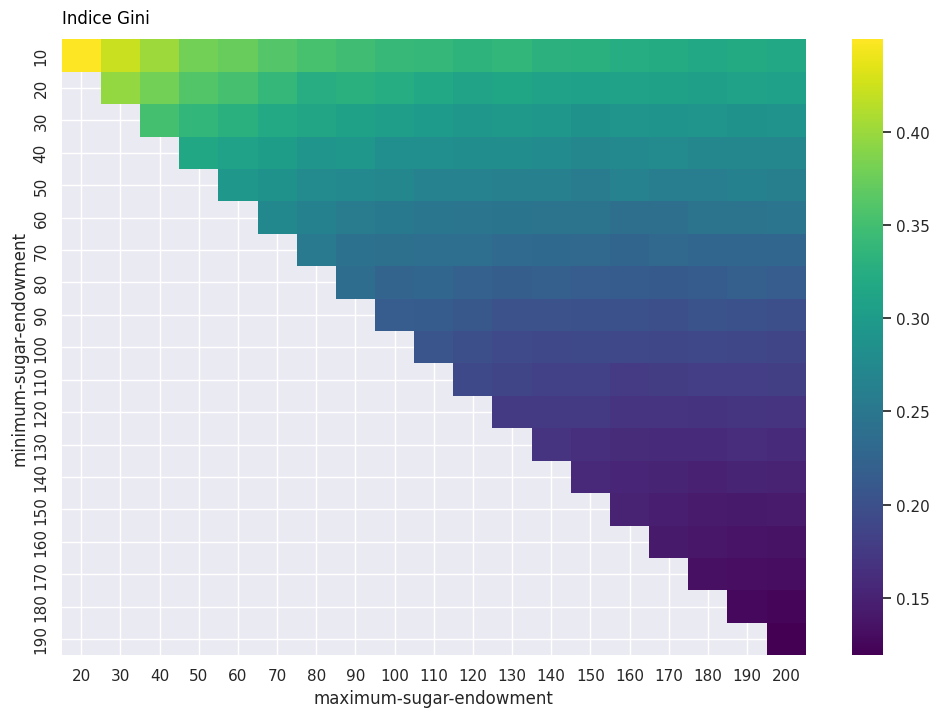

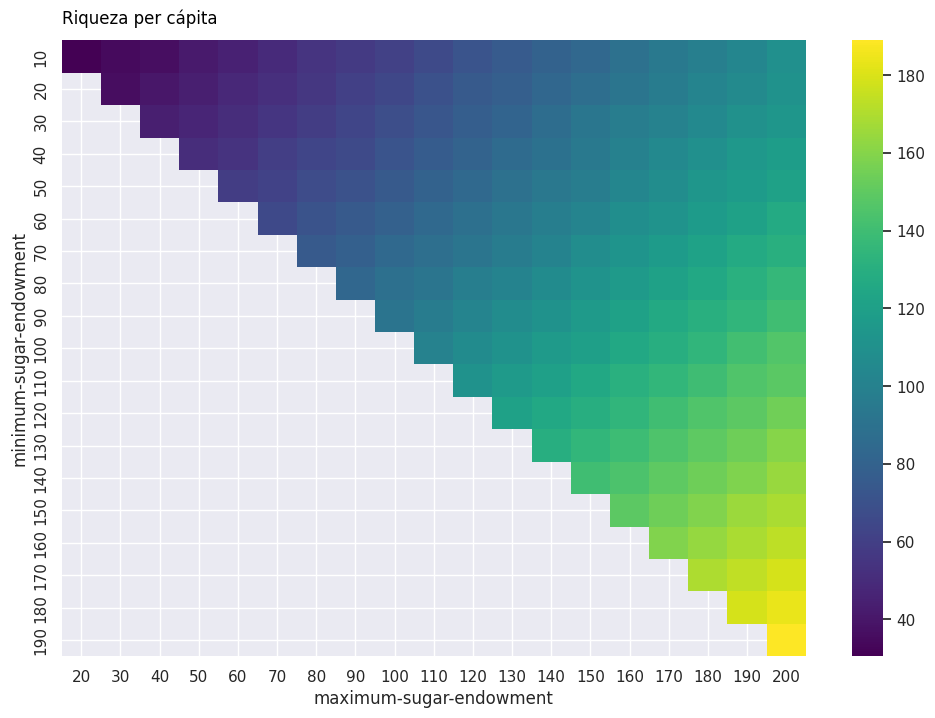

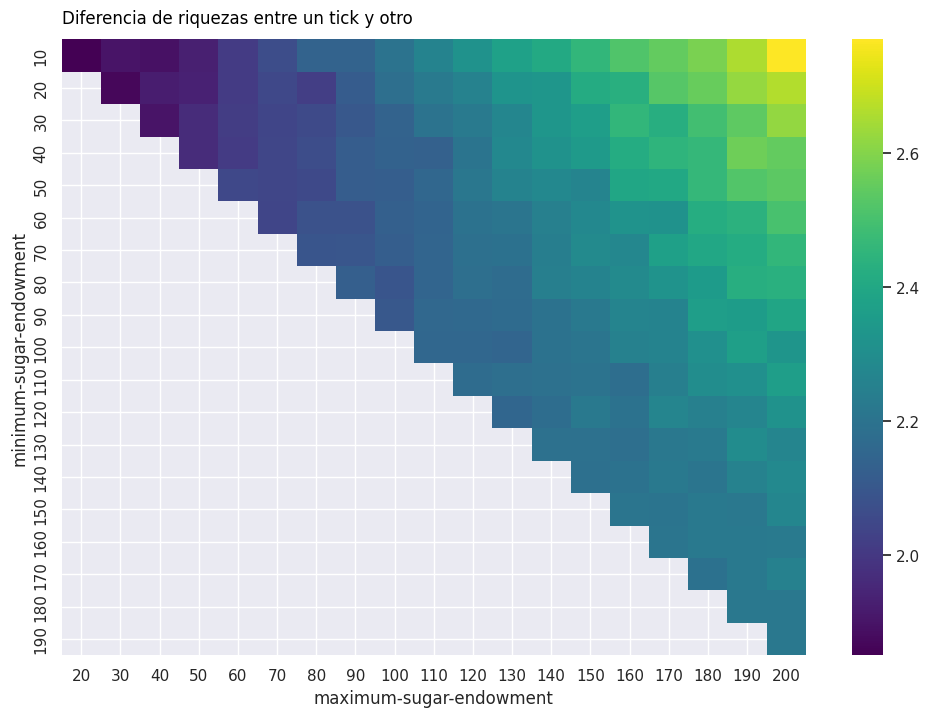

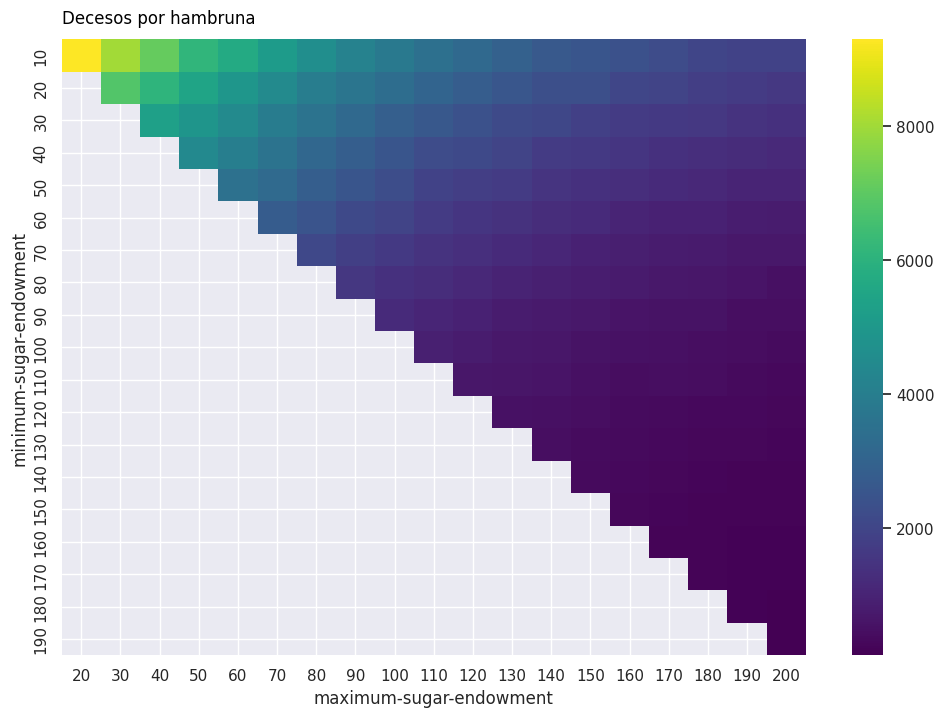

In [6]:
# Observando los resultados del modelo base sin politicas
datos_base = pd.read_csv('base/simple.csv')
datos_base = limpiar_dataframe(datos_base)
for llave in tipos_analisis.keys():
    mapa_calor(datos_base, tipos_analisis[llave], llave, 'figuras/'+llave)



## Cargando los datos arrojados por la implementación de diferentes politicas de recaudación redistribución
Los archivos siguen el patron tipo_recaudación-tipo_redistribución.csv

In [7]:

# patron util para recuperar el tipo de politica de recaudacion y redistribucion
carpeta_datasets = Path('datasets/')
patron = r"(\w+)-(\w+)\.csv$"

for archivo in carpeta_datasets.glob("*.csv"):
    # dataset correspondiende a la implementacion de una politica de recaudacion combinada con una de redistribucion
    df = pd.read_csv(archivo)
    df = limpiar_dataframe(df)
    match = re.match(patron, archivo.name)
    print('cargando: ', archivo.name)
    if match:
        # nombre de la politica de recaudacion y redistribucion
        recaudacion = match.group(1)
        redist = match.group(2)
        nombre = recaudacion +' '+ redist
        nombres_politicas.append(nombre)
        # dataframes pivotados para cada analisis(gini, riqueza, decesos, diferencias) de cada experimento
        for llave in tipos_analisis.keys():
            medida = tipos_analisis[llave]
            datos_aplanados = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values=medida)
            datos_analisis[llave].append(datos_aplanados)
            


cargando:  lineal-dinamico.csv
cargando:  uniforme-dinamico.csv
cargando:  dinamico-uniforme.csv
cargando:  uniforme-lineal.csv
cargando:  lineal-uniforme.csv
cargando:  lineal-dirigidos.csv
cargando:  lineal-lineal.csv
cargando:  dinamico-dinamico.csv
cargando:  uniforme-uniforme.csv
cargando:  dinamico-lineal.csv


# Analizando los resultados
Ahora que ya tenemos los datos con las métricas arrojados por cada uno de los experimentos con las políticas, analicemos los mejores resultados 

## Metodos auxiliares

In [8]:
def menos_es_mejor(iniciales: pd.DataFrame, pivotados: list) -> (pd.DataFrame,pd.DataFrame):
    """
    Metodo auxiliar que compara celda por celda los valores
    de cada dataframe en la lista de pivotados y mantiene
    el valor mas bajo. 
    iniciales : dataframe con resultados por defecto sin politicas
    pivotados : lista de dataframes con datos pivotados
    returns: una tupla con el dataframe de resultados y de etiquetas
    respectivamente. Notese que cada etiqueta corresponde a un indice
    de la lista nombres_politicas
    """
    base = iniciales.copy()
    etiquetas = iniciales.copy()
    etiquetas[~ etiquetas.isnull()] = -1
    for idx in base.index:
        for col  in base.columns:
            if base.loc[idx,col] == base.loc[idx,col]: # evita valores NaN
                for i in range(len(pivotados)):
                    mejor_valor = base.loc[idx,col]
                    politica_actual = pivotados[i]
                    valor_propuesto = politica_actual.loc[idx,col]
                    if valor_propuesto < mejor_valor:
                        base.loc[idx,col] = valor_propuesto
                        etiquetas.loc[idx,col] = i
    return (base,etiquetas)
    
def mas_es_mejor(iniciales: pd.DataFrame, pivotados: list) -> (pd.DataFrame,pd.DataFrame):
    """
    Metodo auxiliar que compara celda por celda los valores
    de cada dataframe en la lista de pivotados y mantiene
    el valor mas alto. 
    iniciales : dataframe con resultados por defecto sin politicas
    pivotados : lista de dataframes con datos pivotados
    returns: una tupla con el dataframe de resultados y de etiquetas
    respectivamente. Notese que cada etiqueta corresponde a un indice
    de la lista nombres_politicas
    """
    base = iniciales.copy()
    etiquetas = iniciales.copy()
    etiquetas[~ etiquetas.isnull()] = -1
    base[~ base.isnull()] = -1
    for idx in base.index:
        for col  in base.columns:
            if base.loc[idx,col] == base.loc[idx,col]: # evita valores NaN
                for i in range(len(pivotados)):
                    politica_actual = pivotados[i]
                    valor_propuesto = politica_actual.loc[idx,col]
                    if valor_propuesto >= base.loc[idx,col] +1: # tolerancia
                        base.loc[idx,col] = valor_propuesto
                        etiquetas.loc[idx,col] = i
    return (base,etiquetas)

def cercano_a_cero(iniciales: pd.DataFrame, pivotados: list) -> (pd.DataFrame,pd.DataFrame):
    """
    Metodo auxiliar que compara celda por celda los valores
    de cada dataframe en la lista de pivotados y mantiene
    el valor mas cercano a cero. 
    iniciales : dataframe con resultados por defecto sin politicas
    pivotados : lista de dataframes con datos pivotados
    returns: una tupla con el dataframe de resultados y de etiquetas
    respectivamente. Notese que cada etiqueta corresponde a un indice
    de la lista nombres_politicas
    """
    base = iniciales.copy()
    etiquetas = iniciales.copy()
    etiquetas[~ etiquetas.isnull()] = -1
    for idx in base.index:
        for col  in base.columns:
            if base.loc[idx,col] == base.loc[idx,col]: # evita valores NaN
                for i in range(len(pivotados)):
                    mejor_valor = abs(base.loc[idx,col])
                    politica_actual = pivotados[i]
                    valor_propuesto = abs(politica_actual.loc[idx,col])
                    if valor_propuesto < mejor_valor:
                        base.loc[idx,col] = valor_propuesto
                        etiquetas.loc[idx,col] = i
    return (base,etiquetas)

def representacion_visual(etiquetas, titulo):
    cmap = sns.color_palette("Set3",len(nombres_politicas))
    # Creamos una máscara para los valores NaN
    mask = etiquetas.isna()
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(etiquetas, annot=True, cmap=cmap, cbar=False, 
                      linewidths=0.5, linecolor='gray', 
                      mask=mask)  # Enmascaramos los NaN

    heatmap.set_facecolor('lightgrey')  # Esto establece un color para los NaN

    cbar = heatmap.figure.colorbar(heatmap.collections[0])
    cbar.set_ticks([i for i in range(10)])  # Posición de las etiquetas
    cbar.set_ticklabels([f"{i}: {nombres_politicas[i]}" for i in range(len(nombres_politicas))])  # Etiquetas en la leyenda
    
    plt.title(titulo)
    plt.show()


## Mejor politica para reducir el indice Gini segun el rango de riqueza inicial

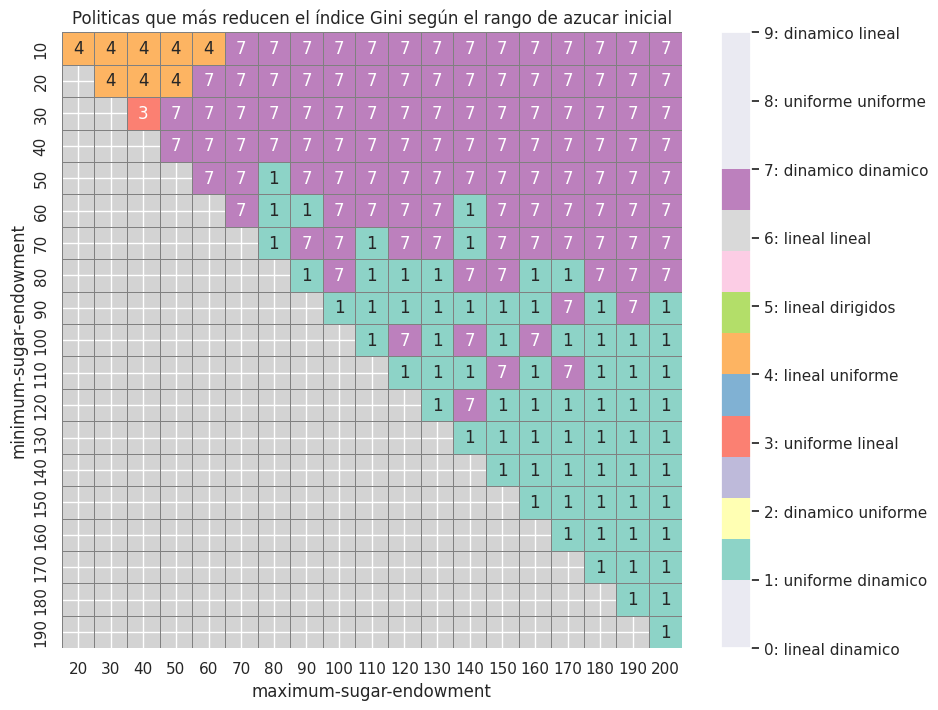

In [9]:
# Los valores base del indice gini del modelo sin politicas
base_gini = datos_base.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values='avg-gini')
pivotados_gini = datos_analisis['Indice Gini']
resultados, etiquetas = menos_es_mejor(iniciales=base_gini, pivotados=pivotados_gini)
representacion_visual(etiquetas,"Politicas que más reducen el índice Gini según el rango de azucar inicial")

## Mejor politica para reducir los decesos por hambruna

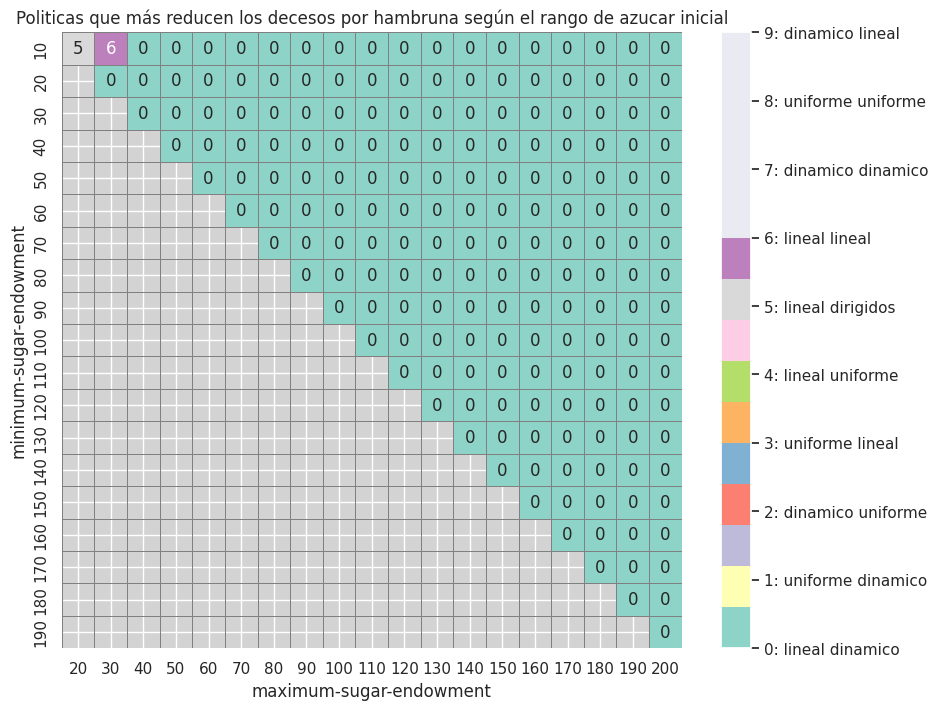

In [10]:
# Los valores base de la cantidad de decesos por hambruna del modelo sin politicas
base_starv = datos_base.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values='starvation')
pivotados_starv= datos_analisis['Decesos por hambruna']
resultados, etiquetas = menos_es_mejor(iniciales=base_starv, pivotados=pivotados_starv)
representacion_visual(etiquetas,"Politicas que más reducen los decesos por hambruna según el rango de azucar inicial")

## Mejor politica para maximizar la riqueza per cápita (Sin contar la no redistribución)

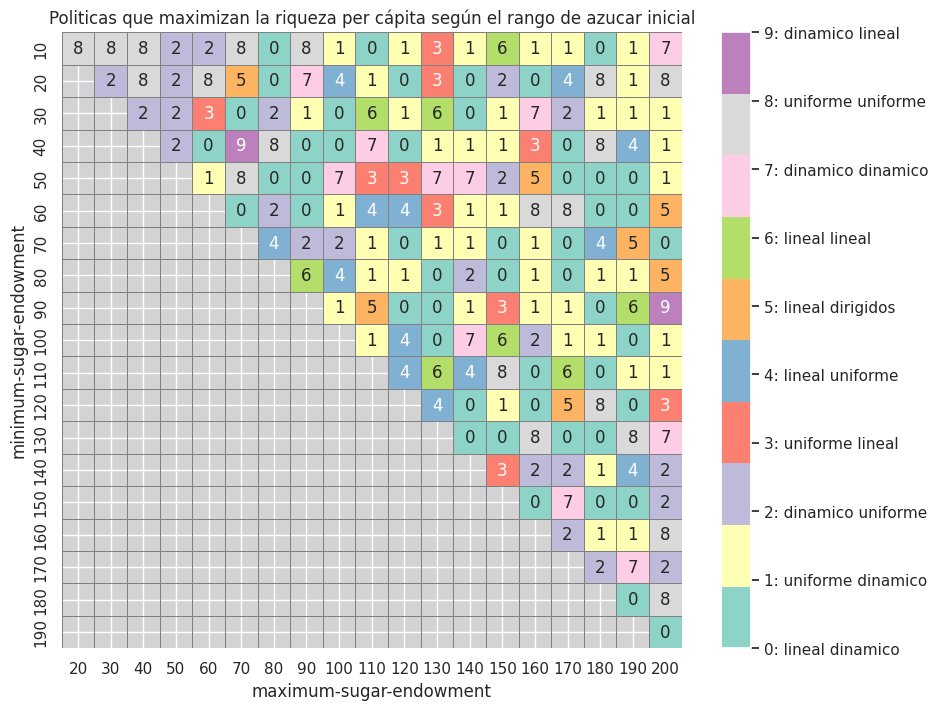

In [11]:
#Sin contar el modelo base:
base_riqueza = datos_analisis['Riqueza per cápita'][0]
pivotados_riqueza = datos_analisis['Riqueza per cápita']
resultados, etiquetas = mas_es_mejor(iniciales=base_riqueza, pivotados=pivotados_riqueza)
representacion_visual(etiquetas,"Politicas que maximizan la riqueza per cápita según el rango de azucar inicial")

In [90]:
resultados

maximum-sugar-endowment,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200
minimum-sugar-endowment,,,,,,,,,,,,,,,,,,,,
0,22.7571,29.015325,32.300225,36.271775,42.579825,47.495100,52.438550,56.047700,60.884825,66.865150,71.389600,76.262075,81.025450,86.740525,90.453225,96.849575,99.212375,105.790625,111.098300,117.711125
10,NaN,31.040325,35.087250,44.406225,45.406350,53.101675,56.826750,59.691575,65.287525,68.827850,78.145250,81.503600,86.710800,93.328825,96.637200,102.092350,107.168900,111.375450,117.815075,121.974075
20,NaN,NaN,42.797575,48.043875,53.078100,58.754225,61.332975,67.809775,69.198125,77.331125,80.121025,85.233200,90.648125,93.374050,102.664650,107.035250,109.889850,117.275700,121.009225,131.975650
30,NaN,NaN,NaN,51.377625,55.816550,59.352525,67.726475,70.146900,78.423475,82.143575,87.702800,90.940975,96.464500,101.830775,108.529700,109.658475,117.820775,121.498700,126.387800,132.983825
40,NaN,NaN,NaN,NaN,61.371000,67.570150,70.511300,73.068650,79.436050,85.314350,92.164675,97.207000,102.019650,106.101125,112.132375,116.316825,122.875550,124.980500,132.679550,135.057350
50,NaN,NaN,NaN,NaN,NaN,72.902325,77.373450,80.836200,86.150025,91.075500,98.827125,100.857000,109.312950,112.658200,116.669500,120.439375,128.451650,130.146675,138.211125,144.567800
60,NaN,NaN,NaN,NaN,NaN,NaN,81.206025,87.055575,93.361025,97.816850,100.126650,105.614625,108.632950,115.397075,122.667400,127.429775,134.723900,136.876325,141.419025,144.085650
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.377000,98.426100,103.672050,105.042700,111.684475,117.035300,123.123800,126.631025,132.222325,135.849275,139.450100,144.815175,152.817725
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.998400,106.806200,111.910200,117.618025,122.782825,125.436825,132.256700,136.420700,140.013275,148.352200,152.447725,158.169850


## Mejor política para minimizar los cambios de azúcar de un tick a otro

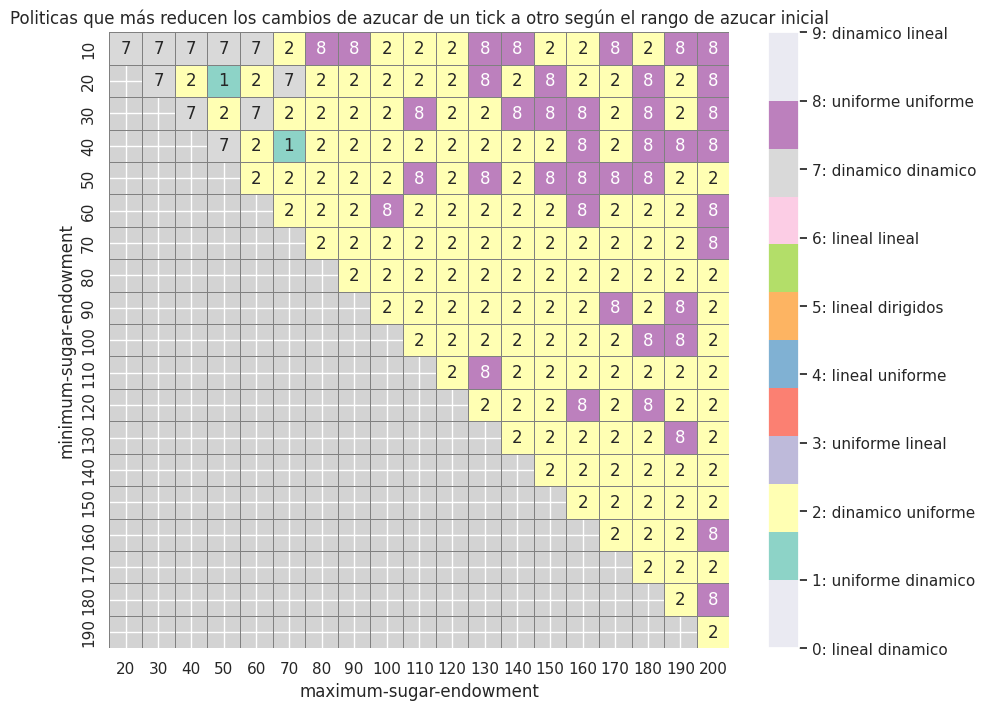

In [12]:

base_cambios = datos_base.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values='avg-diff')
pivotados_diferencia = datos_analisis['Diferencia de riquezas entre un tick y otro']
resultados, etiquetas = cercano_a_cero(iniciales=base_cambios, pivotados= pivotados_diferencia)
representacion_visual(etiquetas,"Politicas que más reducen los cambios de azucar de un tick a otro según el rango de azucar inicial")

### Sin tomar en cuenta la no redistribución:

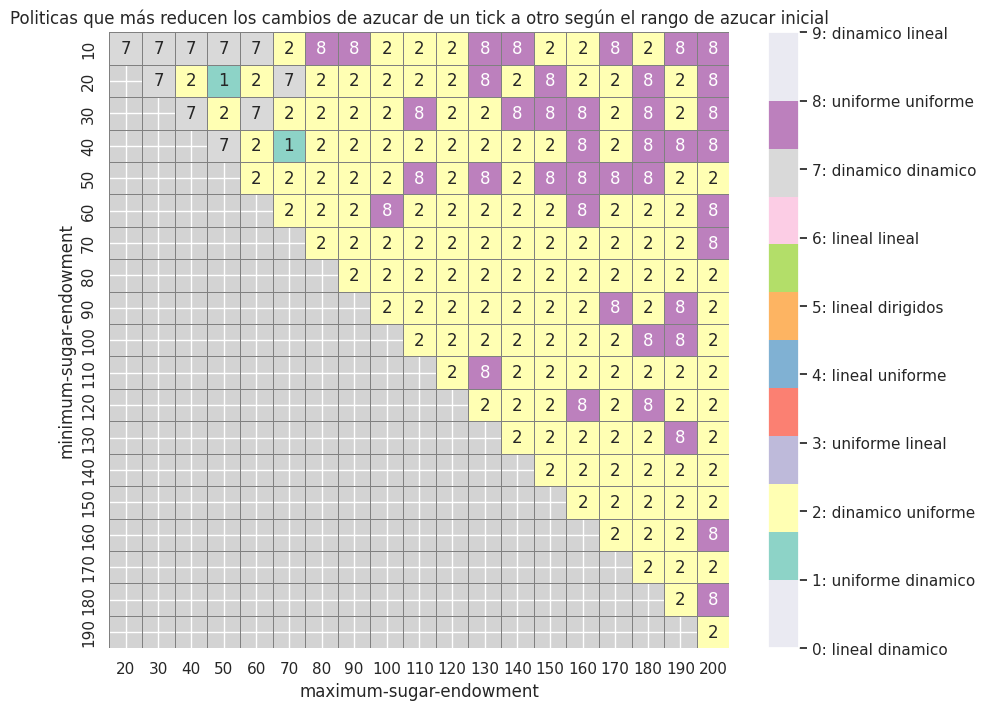

In [13]:
base_cambios = datos_analisis['Diferencia de riquezas entre un tick y otro'][0]
pivotados_diferencia = datos_analisis['Diferencia de riquezas entre un tick y otro']
resultados, etiquetas = cercano_a_cero(iniciales=base_cambios, pivotados= pivotados_diferencia)
representacion_visual(etiquetas,"Politicas que más reducen los cambios de azucar de un tick a otro según el rango de azucar inicial")